In [53]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [54]:
crashes = pd.read_csv('dataset/crashes_cleaned.csv')

In [55]:
len(crashes)

841633

In [56]:
crashes.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841633 entries, 0 to 841632
Data columns (total 63 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CRASH_RECORD_ID                   841633 non-null  object 
 1   CRASH_DATE                        841633 non-null  object 
 2   POSTED_SPEED_LIMIT                841633 non-null  int64  
 3   WEATHER_SEVERITY                  841633 non-null  int64  
 4   LIGHTING_SEVERITY                 841633 non-null  int64  
 5   FIRST_CRASH_TYPE                  841633 non-null  object 
 6   TRAFFICWAY_TYPE                   841633 non-null  object 
 7   ROADWAY_SEVERITY                  841633 non-null  int64  
 8   CRASH_TYPE                        841633 non-null  object 
 9   DAMAGE_SEVERITY                   841633 non-null  int64  
 10  PRIM_CONTRIBUTORY_CAUSE           841633 non-null  object 
 11  SEC_CONTRIBUTORY_CAUSE            841633 non-null  o

In [57]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841633 entries, 0 to 841632
Data columns (total 63 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CRASH_RECORD_ID                   841633 non-null  object 
 1   CRASH_DATE                        841633 non-null  object 
 2   POSTED_SPEED_LIMIT                841633 non-null  int64  
 3   WEATHER_SEVERITY                  841633 non-null  int64  
 4   LIGHTING_SEVERITY                 841633 non-null  int64  
 5   FIRST_CRASH_TYPE                  841633 non-null  object 
 6   TRAFFICWAY_TYPE                   841633 non-null  object 
 7   ROADWAY_SEVERITY                  841633 non-null  int64  
 8   CRASH_TYPE                        841633 non-null  object 
 9   DAMAGE_SEVERITY                   841633 non-null  int64  
 10  PRIM_CONTRIBUTORY_CAUSE           841633 non-null  object 
 11  SEC_CONTRIBUTORY_CAUSE            841633 non-null  o

In [58]:

crashes["CRASH_YEAR"] = crashes["CRASH_YEAR"].astype(int)
crashes["CRASH_MONTH"] = crashes["CRASH_MONTH"].astype(int)
crashes["BEAT_OF_OCCURRENCE"] = crashes["BEAT_OF_OCCURRENCE"].astype(float)
crashes["AGE"] = pd.to_numeric(crashes["AGE"], errors="coerce")

# Identify all categorical columns dynamically (all starting with 'CATEGORY_', 'LIGHTING_CATEGORY_', 'ROADWAY_SURFACE_CATEGORY_', etc.)
categorical_columns = [col for col in crashes.columns if col.startswith(
    ("CATEGORY_", "LIGHTING_CATEGORY_", "ROADWAY_SURFACE_CATEGORY_", "ROAD_DEFECT_CATEGORY_", "DAMAGE_CATEGORY_"))]
crashes[categorical_columns] = crashes[categorical_columns].apply(pd.to_numeric, errors="coerce")

# Feature Engineering: Creating new indicators
crashes["fatality_rate"] = crashes["INJURIES_FATAL"] / (crashes["INJURIES_TOTAL"] + 1)
crashes["severe_injury_rate"] = crashes["INJURIES_INCAPACITATING"] / (crashes["INJURIES_TOTAL"] + 1)
crashes["severity_score"] = (
    (1 * crashes["INJURIES_NON_INCAPACITATING"]) +
    (2 * crashes["INJURIES_INCAPACITATING"]) +
    (3 * crashes["INJURIES_FATAL"])
)
crashes["vehicle_involvement_rate"] = crashes["NUM_UNITS"] / crashes.groupby(["CRASH_YEAR", "CRASH_MONTH", "BEAT_OF_OCCURRENCE"]).transform("count")["CRASH_RECORD_ID"]
crashes["night_crash_rate"] = crashes["LIGHTING_CATEGORY_NIGHT"].astype(int)
crashes["adverse_weather_crash_rate"] = crashes[["WEATHER_CATEGORY_RAIN", "WEATHER_CATEGORY_EXTREME"]].sum(axis=1)
crashes["road_defect_crash_rate"] = crashes[["ROAD_DEFECT_CATEGORY_BAD", "ROAD_DEFECT_CATEGORY_DEFECT", "ROAD_DEFECT_CATEGORY_DEBRIS"]].sum(axis=1)
crashes["speeding_influence"] = (crashes["POSTED_SPEED_LIMIT"] > 50).astype(int)
crashes["weekend_crash_rate"] = (crashes["CRASH_DAY_OF_WEEK"].isin([6, 7])).astype(int)

# Define neo-patented and senior drivers
crashes["neo_patented_drivers"] = (crashes["AGE"] <= 21).astype(int)
crashes["senior_drivers"] = (crashes["AGE"] >= 65).astype(int)

# Grouping by year, month, and police department
incident_profile = crashes.groupby(["CRASH_YEAR", "CRASH_MONTH", "BEAT_OF_OCCURRENCE"]).agg(
    avg_age=("AGE", "mean"),
    avg_responsibility_score=("responsibility_score", "mean"),
    high_responsibility_crashes=("responsibility_score", lambda x: (x >= 0.8).mean()),
    avg_weather_severity=("WEATHER_SEVERITY", "mean"),
    avg_roadway_severity=("ROADWAY_SEVERITY", "mean"),
    avg_lighting_severity=("LIGHTING_SEVERITY", "mean"),
    total_crashes=("CRASH_RECORD_ID", "count"),
    fatality_rate=("fatality_rate", "mean"),
    severe_injury_rate=("severe_injury_rate", "mean"),
    avg_crash_severity_score=("crash_severity_score", "mean"),
    severity_score=("severity_score", "sum"),
    vehicle_involvement_rate=("vehicle_involvement_rate", "mean"),
    night_crash_rate=("night_crash_rate", "mean"),
    adverse_weather_crash_rate=("adverse_weather_crash_rate", "mean"),
    road_defect_crash_rate=("road_defect_crash_rate", "mean"),
    speeding_influence=("speeding_influence", "mean"),
    weekend_crash_rate=("weekend_crash_rate", "mean"),
    neo_patented_drivers=("neo_patented_drivers", "sum"),
    senior_drivers=("senior_drivers", "sum"),
    **{f"sum_{col.lower()}": (col, "sum") for col in categorical_columns}
).reset_index()


# Save the result to a CSV file
incident_profile.to_csv("dataset/incident_profile.csv", index=False)

# Display the first few rows
incident_profile.head()


,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_age,avg_responsibility_score,high_responsibility_crashes,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,severity_score,vehicle_involvement_rate,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial
0,2017,1,111.0,48.525000,0.545000,0.000000,0.500000,0.200000,0.550000,20,0.0,0.000000,0.440000,0.0,0.100000,0.500000,0.200000,0.000000,0.0,0.150000,0,4,10,10,0,14,6,0,0,0,19,0,0,0,1,11,3,6,0.0,0.0,28.0,1.0,3.0
1,2017,1,112.0,44.823529,0.488889,0.000000,0.611111,0.277778,0.555556,18,0.0,0.000000,0.433333,0.0,0.111111,0.388889,0.277778,0.000000,0.0,0.000000,0,1,10,7,1,13,4,0,1,0,16,0,0,0,2,7,5,6,0.0,0.0,30.0,0.0,2.0
2,2017,1,113.0,44.388889,0.505000,0.100000,0.300000,0.000000,0.250000,20,0.0,0.000000,0.465000,0.0,0.105000,0.250000,0.150000,0.000000,0.0,0.050000,0,1,14,5,1,15,4,0,0,1,17,0,0,0,3,13,4,3,0.0,0.0,37.0,1.0,0.0
3,2017,1,114.0,42.208333,0.501887,0.037736,0.264151,0.226415,0.566038,53,0.0,0.012579,0.515094,4.0,0.037736,0.452830,0.150943,0.037736,0.0,0.094340,0,3,29,24,0,38,10,1,1,3,44,2,0,0,7,23,15,15,0.0,0.0,80.0,2.0,4.0
4,2017,1,121.0,39.703125,0.450000,0.000000,0.444444,0.166667,0.555556,36,0.0,0.000000,0.436111,0.0,0.055556,0.416667,0.222222,0.027778,0.0,0.055556,2,1,21,15,0,23,12,0,0,1,29,0,0,1,6,24,5,7,0.0,0.0,57.0,2.0,3.0


In [59]:
incident_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26185 entries, 0 to 26184
Data columns (total 43 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CRASH_YEAR                            26185 non-null  int64  
 1   CRASH_MONTH                           26185 non-null  int64  
 2   BEAT_OF_OCCURRENCE                    26185 non-null  float64
 3   avg_age                               26180 non-null  float64
 4   avg_responsibility_score              26185 non-null  float64
 5   high_responsibility_crashes           26185 non-null  float64
 6   avg_weather_severity                  26185 non-null  float64
 7   avg_roadway_severity                  26185 non-null  float64
 8   avg_lighting_severity                 26185 non-null  float64
 9   total_crashes                         26185 non-null  int64  
 10  fatality_rate                         26185 non-null  float64
 11  severe_injury_r

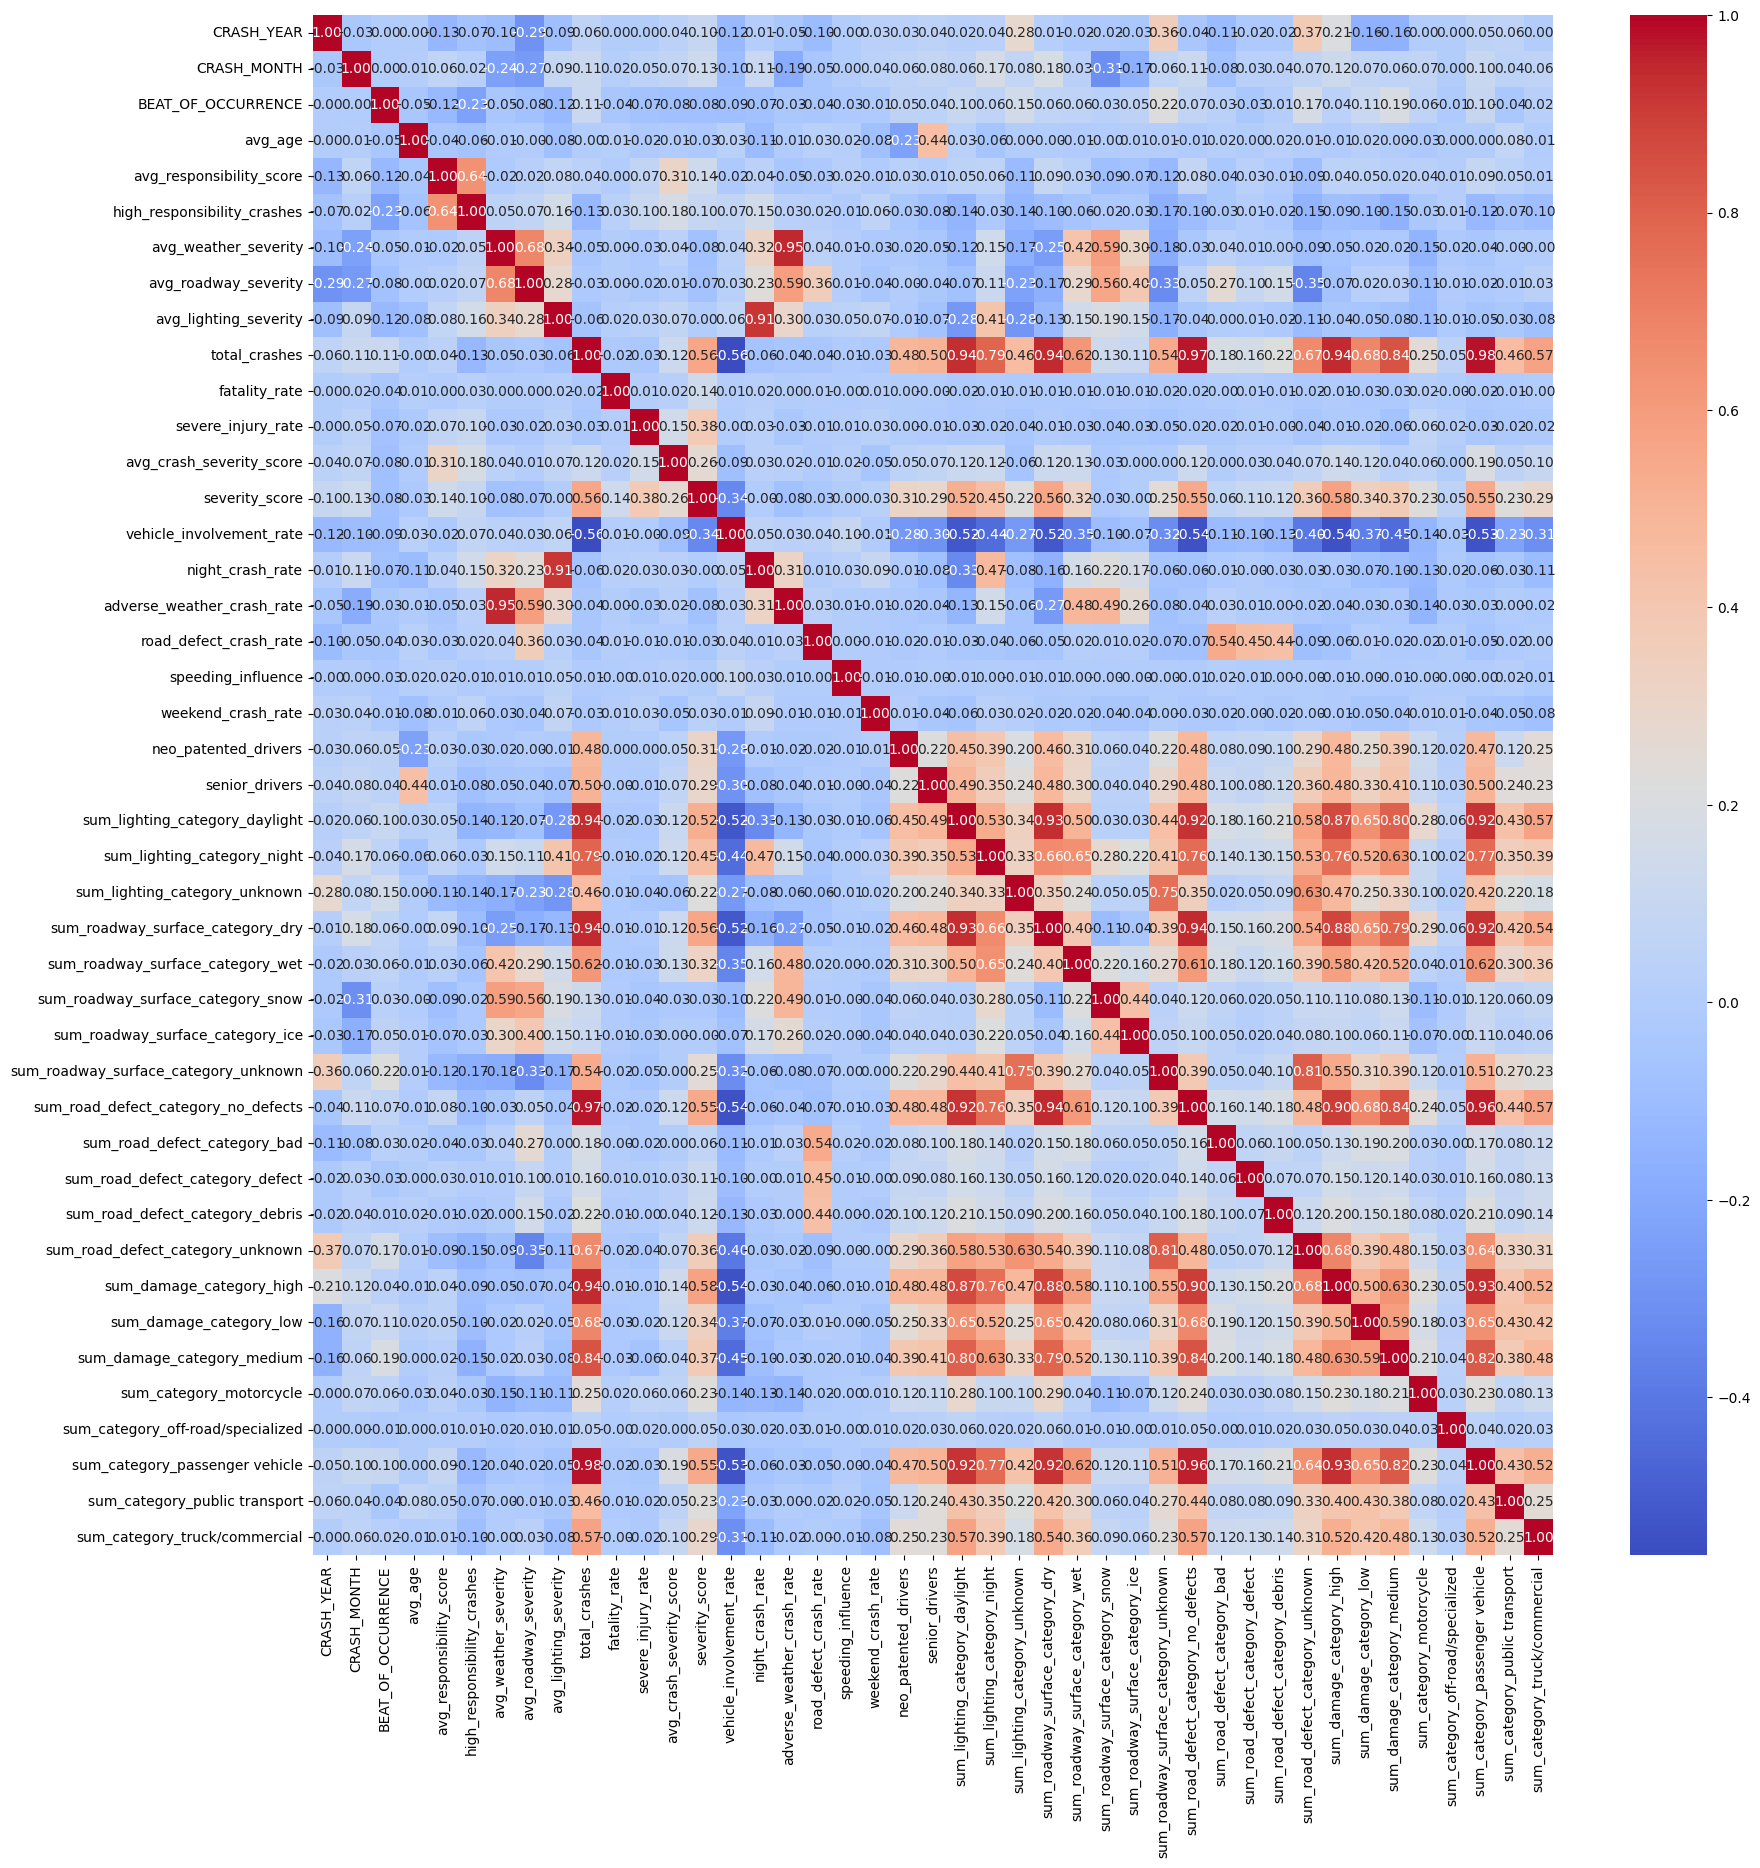

In [60]:
# plot correlation matric for incident_profile
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(incident_profile.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()




In [61]:
# columns to analize

columns = ['avg_age', 'avg_responsibility_score', 'high_responsibility_crashes', 'avg_weather_severity',
           'avg_roadway_severity', 'avg_lighting_severity', 'total_crashes', 'fatality_rate',
           'severe_injury_rate', 'avg_crash_severity_score', 'severity_score', 'vehicle_involvement_rate',
           'night_crash_rate', 'adverse_weather_crash_rate', 'road_defect_crash_rate', 'speeding_influence',
           'weekend_crash_rate', 'neo_patented_drivers', 'senior_drivers']

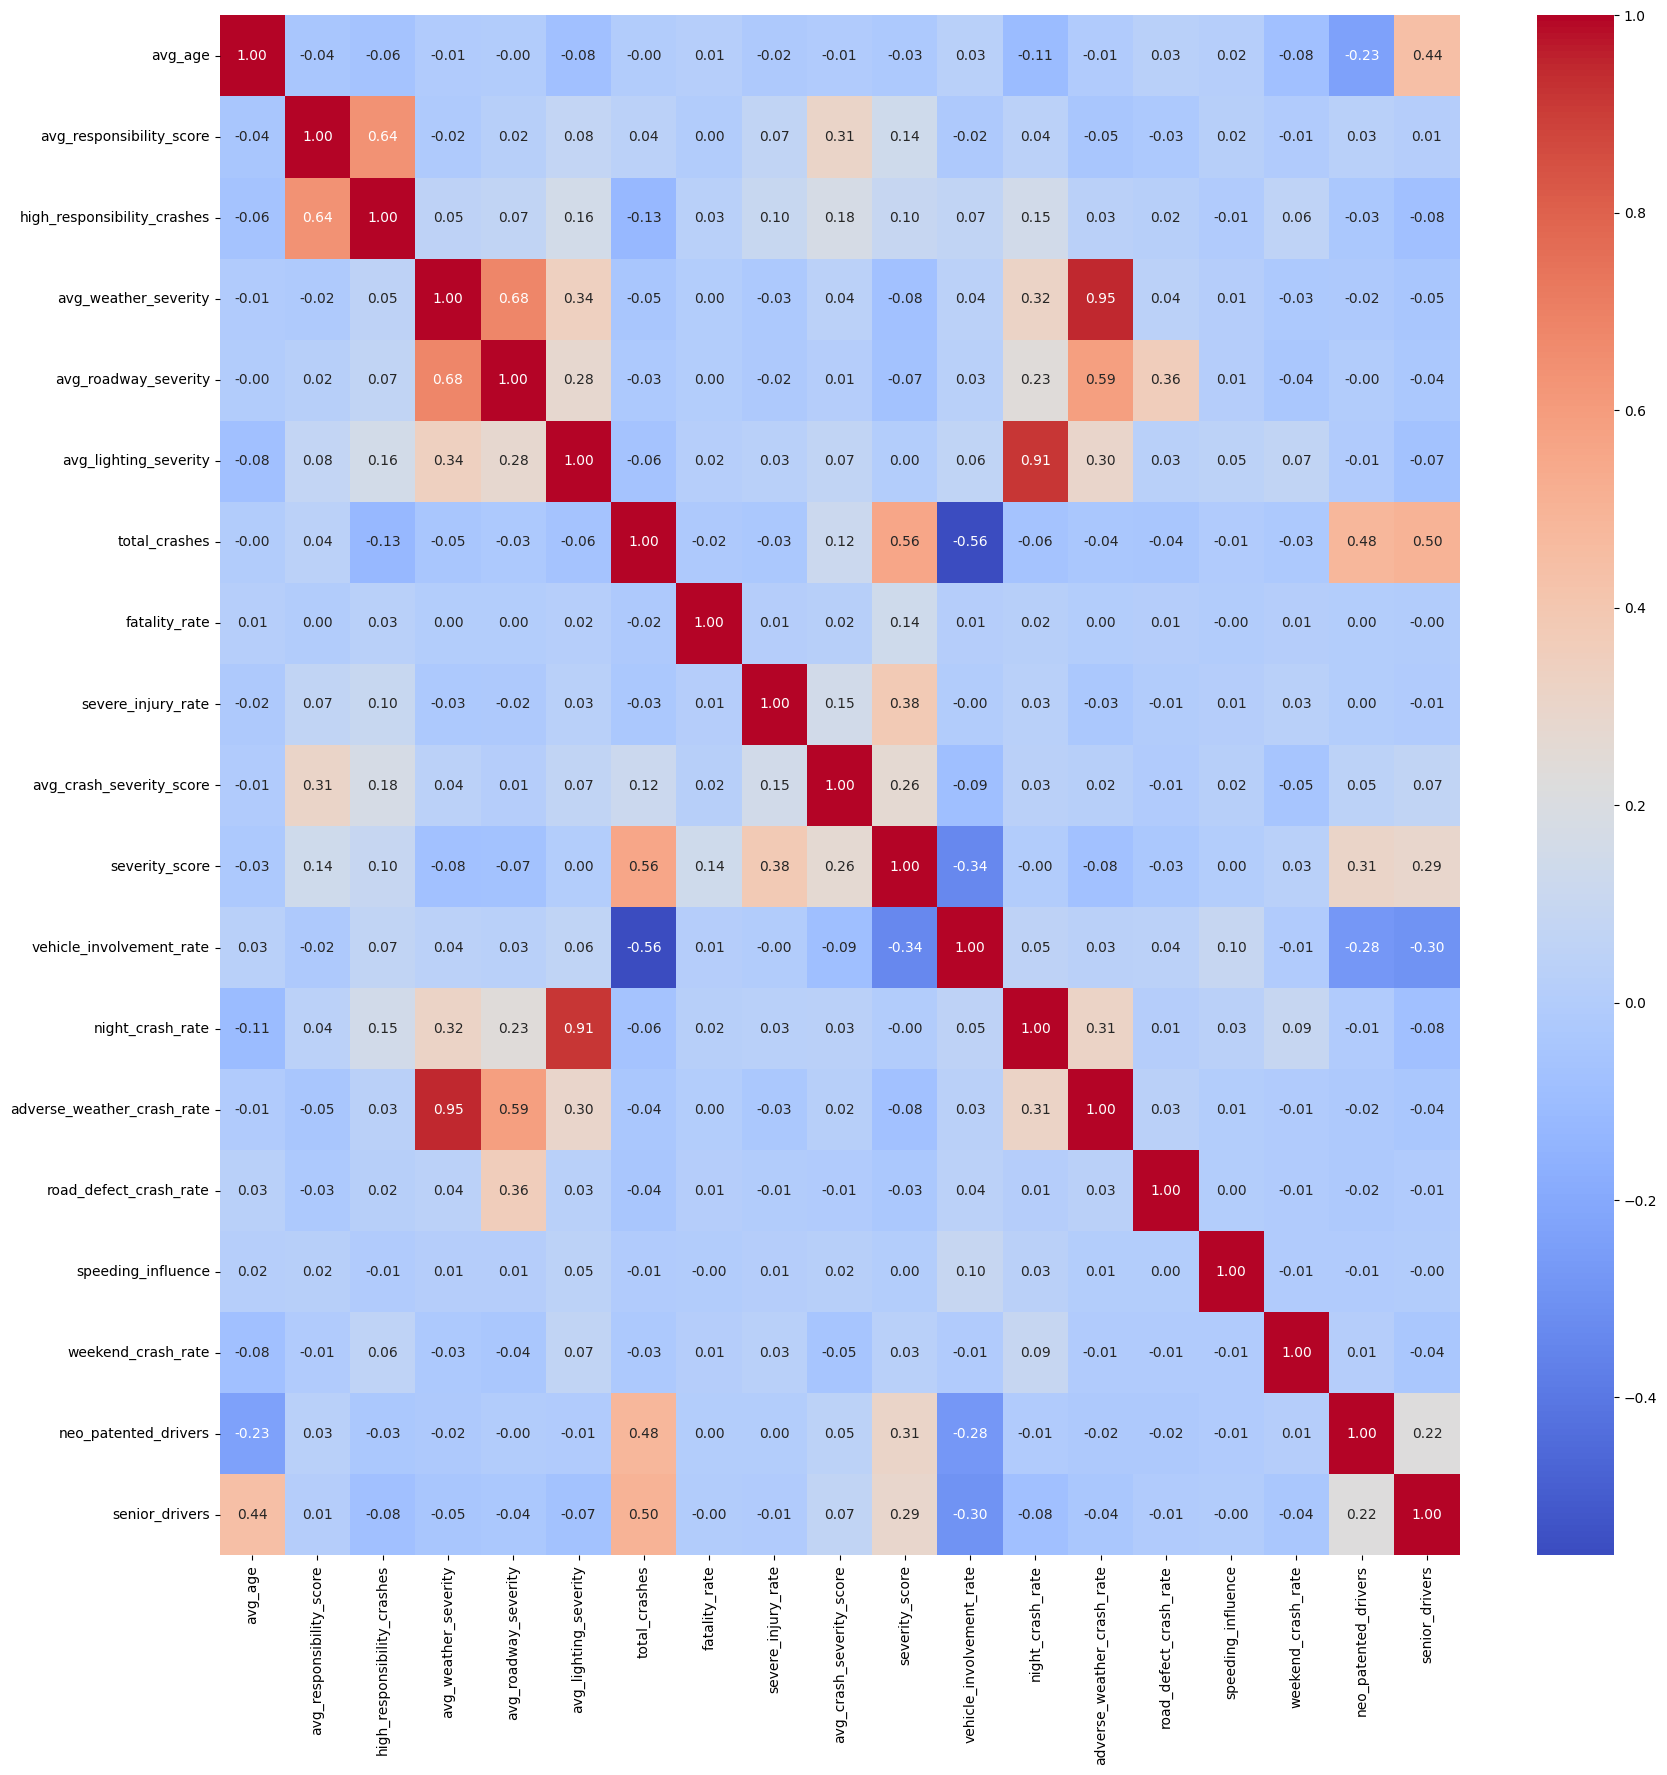

In [62]:
plt.figure(figsize=(20, 20))
sns.heatmap(incident_profile[columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()